<a href="https://colab.research.google.com/github/Dany-Santi-TSAN/computer-vision/blob/main/cifar_class_with_data_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

from keras.datasets import cifar10
import numpy as np

# Data viz
import matplotlib.pyplot as plt

# Preprocessing
from tensorflow.keras.utils import to_categorical

# Model Neural Network
from keras import Sequential, Input, layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-cifar-classification')

## Train, Test, split Cifar dataset

In [5]:
(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()

labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


{np.uint8(0): np.int64(5000),
 np.uint8(1): np.int64(5000),
 np.uint8(2): np.int64(5000),
 np.uint8(3): np.int64(5000),
 np.uint8(4): np.int64(5000),
 np.uint8(5): np.int64(5000),
 np.uint8(6): np.int64(5000),
 np.uint8(7): np.int64(5000),
 np.uint8(8): np.int64(5000),
 np.uint8(9): np.int64(5000)}

## Subsampling Training and Test Datasets

This code reduces the size of the training and test datasets by a specified reduction factor and prints the shapes of the original and subsampled datasets. It also calculates and displays the distribution of labels in the subsampled training set.


In [6]:
# Define the reduction factor for subsampling the dataset
reduction_factor = 10

# Randomly select indices for the training set
# The number of selected indices is approximately 1/10th of the original training set size
idx_train = np.random.choice(len(images_train), round(len(images_train) / reduction_factor), replace=False)

# Randomly select indices for the test set
# The number of selected indices is approximately 1/10th of the original test set size
idx_test = np.random.choice(len(images_test), round(len(images_test) / reduction_factor), replace=False)

# Create subsamples of the training images and their corresponding labels using the selected indices
images_train_small = images_train[idx_train]
labels_train_small = labels_train[idx_train]

# Create subsamples of the test images and their corresponding labels using the selected indices
images_test_small = images_test[idx_test]
labels_test_small = labels_test[idx_test]

# Print the shapes of the original training and test sets
print("------------------ Before -----------------")
print(f"Training set shape: {images_train.shape}")
print(f"Test set shape: {images_test.shape}")

print("")

# Print the shapes of the subsampled training and test sets
print("--- After applying the reduction factor ---")
print(f"Subsampled training set shape: {images_train_small.shape}")
print(f"Subsampled test set shape: {images_test_small.shape}")

print("")
print("-" * 43)

# Calculate the unique labels and their counts in the subsampled training set
unique, counts = np.unique(labels_train_small, return_counts=True)

# Create a dictionary to map each unique label to its count
label_counts = dict(zip(unique, counts))

# Print the label counts
print("Label counts in the subsampled training set:")
print(label_counts)

------------------ Before -----------------
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)

--- After applying the reduction factor ---
Subsampled training set shape: (5000, 32, 32, 3)
Subsampled test set shape: (1000, 32, 32, 3)

-------------------------------------------
Label counts in the subsampled training set:
{np.uint8(0): np.int64(489), np.uint8(1): np.int64(502), np.uint8(2): np.int64(499), np.uint8(3): np.int64(508), np.uint8(4): np.int64(478), np.uint8(5): np.int64(483), np.uint8(6): np.int64(505), np.uint8(7): np.int64(504), np.uint8(8): np.int64(518), np.uint8(9): np.int64(514)}


## Let's plot few images to see what they look like

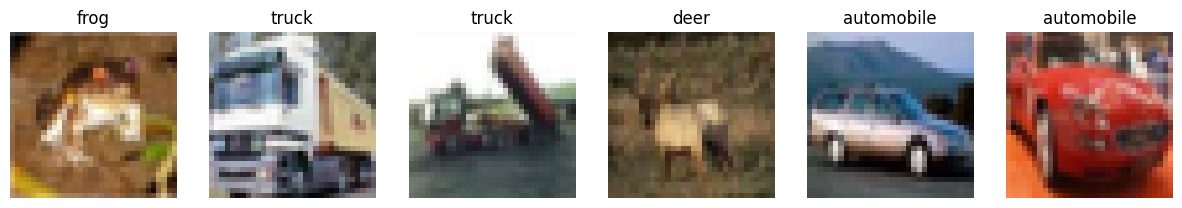

In [7]:
# Loop through the first 6 images in the training set

plt.figure(figsize=(15,5))

for i in range(6):
    plt.subplot(1,6, i+1)

    # Get the image and its corresponding label
    img = images_train[i]
    label = labels_train[i][0]
    plt.imshow(img)
    plt.title(labels[label])

    # Remove the axes for a cleaner look
    plt.axis('off')

## Preprocessing Steps for Image Classification

Normalization and One-Hot Encoding for Neural Network Training

the code provided is a preprocessing step commonly used in machine learning workflows, particularly for image data.

In [8]:
### Normalizing pixels' intensities
# Normalize the pixel values of the training and test sets to the range [0, 1]
X_train = images_train / 255.
X_train_small = images_train_small / 255.
X_test = images_test / 255.
X_test_small = images_test_small / 255.

### Encoding the labels
# Convert the labels to one-hot encoded vectors
y_train = to_categorical(labels_train, 10)
y_train_small = to_categorical(labels_train_small, 10)
y_test = to_categorical(labels_test, 10)
y_test_small = to_categorical(labels_test_small, 10)

## CNN

In [9]:
def initialize_model():
    """
    Initialize and return a Convolutional Neural Network (CNN) model for image classification.

    """
    # Create a Sequential model, which is a linear stack of layers
    model = Sequential()
    # Define the input shape of the image (size 32x32 px and RGB channels by 3)
    model.add(Input(shape=(32, 32, 3)))

    '''
    First convolutional layer with 16 filters, each of size 3x3
    'relu' activation function introduces non-linearity
    'same' padding ensures the output has the same dimensions as the input
    MaxPooling layer to downsample the input by taking the maximum value over a 2x2 window
    Prevent overfitting with Dropout layer with 20% dropout rate
    '''
    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Second convolutional layer rise by 32 filters, each of size 3x3

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Third convolutional layer rise by 64 filters, each of size 2x2

    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    # Output layer with 10 units (assuming 10 classes) and 'softmax' activation function to output
    model.add(Dense(10, activation = 'softmax'))

    return model

In [10]:
model = initialize_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       102,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,854 (456.46 KB)

 Trainable params: 116,854 (456.46 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def compile_model(model):
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    return model

## Training the CNN Model on Subsampled Data

The code cells include model initialization, compilation, early stopping setup, the training process and plot history for checking overtifitting.

In [12]:
model_small = initialize_model()
model_small = compile_model(model)

es = EarlyStopping(patience = 5, verbose = 2)

history_small = model_small.fit(X_train_small, y_train_small,
                    validation_split = 0.3,
                    callbacks = [es],
                    epochs = 100,
                    batch_size = 64)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.1114 - loss: 2.3261 - val_accuracy: 0.1833 - val_loss: 2.2421
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.1718 - loss: 2.1731 - val_accuracy: 0.2720 - val_loss: 2.0757
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.2506 - loss: 2.0283 - val_accuracy: 0.3427 - val_loss: 1.9631
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.2948 - loss: 1.9099 - val_accuracy: 0.3453 - val_loss: 1.8908
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3384 - loss: 1.8381 - val_accuracy: 0.4080 - val_loss: 1.8115
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.3607 - loss: 1.7492 - val_accuracy: 0.4100 - val_loss: 1.7628
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3863 - loss: 1.6814 - val_accuracy: 0.4307 - val_loss: 1.6485
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4158 - loss: 1.6153 - val_accurac

In [13]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

### Training and Validation Performance

The following plots show the training and validation performance of the CNN model over 50 epochs.

#### Loss Plot
- **X-axis**: Number of epochs.
- **Y-axis**: Loss value.
- **Blue Curve**: Training loss.
- **Orange Curve**: Validation loss.
- **Observation**: The loss decreases over epochs, indicating that the model is learning. However, the validation loss is generally higher than the training loss, which may suggest slight overfitting.

#### Accuracy Plot
- **X-axis**: Number of epochs.
- **Y-axis**: Accuracy value.
- **Blue Curve**: Training accuracy.
- **Orange Curve**: Validation accuracy.
- **Observation**: The accuracy increases over epochs, indicating that the model is becoming more accurate. The validation accuracy is generally lower than the training accuracy, which may also suggest slight overfitting.

These plots help monitor the model's performance and detect potential overfitting during training.


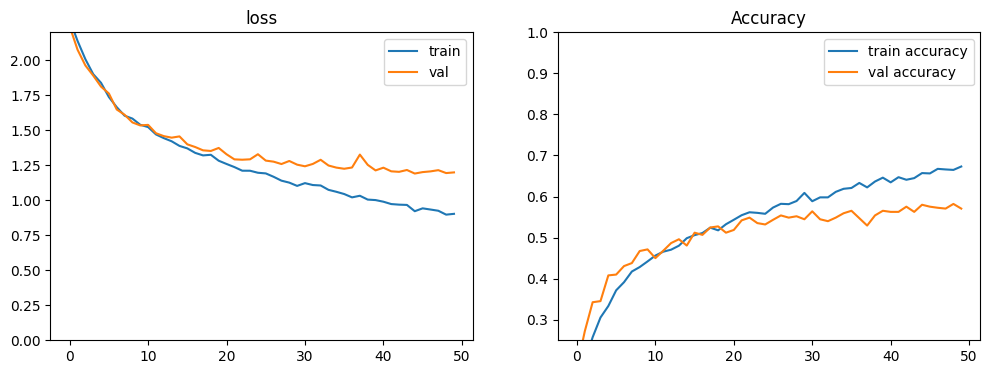

In [14]:
plot_history(history_small)
plt.show()

In [15]:
res = model_small.evaluate(X_test_small, y_test_small, verbose = 2)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')


32/32 - 0s - 13ms/step - accuracy: 0.5310 - loss: 1.2919
The accuracy is 53.1% compared to a chance level of 10.0%


#### Model Performance Analysis
The model achieved an accuracy of 53.1% on the test dataset.
To evaluate this performance, we compare it to the chance level, which is the accuracy expected from random guessing. For a classification task with 10 classes, the chance level is 10% (1/10)

**Accuracy**: 53.1%

**Chance Level**: 10%

**Interpretation**:

The model's accuracy of 53.1% is significantly higher than the chance level, indicating that the model has learned meaningful patterns from the data and is performing better than random guessing.

However, while the model shows improvement over random predictions, a 53.1% accuracy may not be sufficient for practical applications. There is still room for improvement.

#### Suggestions to Improve Performance:

**Data Augmentation**: Use data augmentation techniques to increase the diversity of the training data.

**Hyperparameters**: Adjust the model's hyperparameters, such as the learning rate, the number of layers, the number of neurons per layer, etc.

**Regularization**: Use regularization techniques like dropout, L2 regularization, etc., to prevent overfitting.

**More Data**: If possible, increase the size of the training dataset.

**Model Architecture**: Try different model architectures or more complex models.

### Let's try with full dataset

Initially, I trained the model_small using only **10% of the dataset**, which resulted in an **accuracy of 53.1%**.
While this was better than the chance level of 10%, it was clear that the model needed improvement.

To enhance the model's performance, I took the following steps:

Step 1 - **Increased the Dataset Size**:

I used the full dataset instead of the subsampled version. This provided the model with more data to learn from, which is crucial for improving generalization.

In [16]:
%%time
model = initialize_model()
model = compile_model(model)

es = EarlyStopping(patience = 5)

history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    callbacks = [es],
                    epochs = 100,
                    batch_size = 64,
                   verbose = 1)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.2270 - loss: 2.0775 - val_accuracy: 0.4397 - val_loss: 1.6683
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.4167 - loss: 1.6018 - val_accuracy: 0.5031 - val_loss: 1.4472
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.4764 - loss: 1.4527 - val_accuracy: 0.5383 - val_loss: 1.3463
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.5038 - loss: 1.3690 - val_accuracy: 0.5721 - val_loss: 1.2441
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.5310 - loss: 1.3120 - val_accuracy: 0.5773 - val_loss: 1.2415
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step - accuracy: 0.5418 - loss: 1.2726 - val_accuracy: 0.5986 - val_loss: 1.1770
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.5636 - loss: 1.2235 - val_accuracy: 0.6245 - val_loss: 1.1144
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 87s 84ms/step - accuracy: 0.5744 - loss: 1

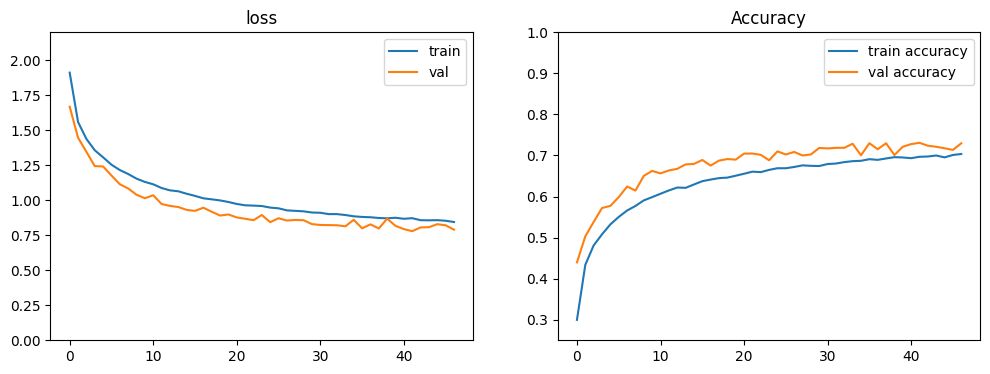

In [17]:
plot_history(history);

In [19]:
res = model.evaluate(X_test, y_test, verbose = 0)

print(f'The accuracy is {res[1]*100:.3f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 72.490% compared to a chance level of 10.0%


After training the model on the full dataset, the model achieved an accuracy of 72.49%. This is a significant improvement compared to the initial accuracy of 53.1% obtained with only 10% of the data.

### Conclusion
Increasing the dataset size has allowed the model to learn more effectively and generalize better. This confirms the importance of having sufficient data for training deep learning models.


### Data Augmentation

**Step 2 - Applied Data Augmentation**:

Data augmentation is **a technique to artificially increase the diversity of the training data by applying random transformations**. This helps the model generalize better and reduces overfitting.

I used the ImageDataGenerator from Keras with the following transformations:

- **Rotation**: Randomly rotate images within a range of 10 degrees.
- **Width and Height Shifts**: Randomly shift images horizontally and vertically by up to 10% of their dimensions.
- **Horizontal Flip**: Randomly flip images horizontally.
- **Zoom**: Randomly zoom in and out of images within a range of 80% to 120%.

In [20]:
# Create a data augmentation generator
datagen = ImageDataGenerator(
    featurewise_center=False,          # Do not center the data
    featurewise_std_normalization=False,  # Do not normalize the data
    rotation_range=10,                # Randomly rotate images within 10 degrees
    width_shift_range=0.1,            # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,           # Randomly shift images vertically by up to 10%
    horizontal_flip=True,             # Randomly flip images horizontally
    zoom_range=(0.8, 1.2),            # Randomly zoom in and out of images
)

# Fit the data augmentation generator to the training data
datagen.fit(X_train)

In [21]:
datagen

In [22]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

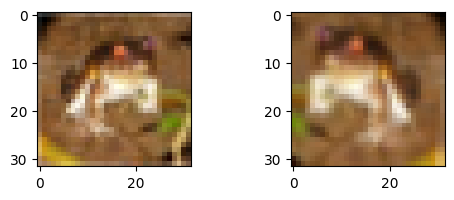

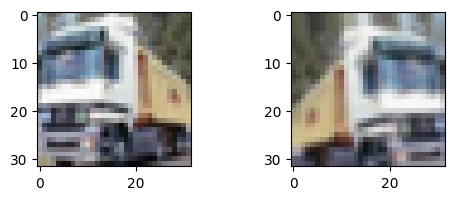

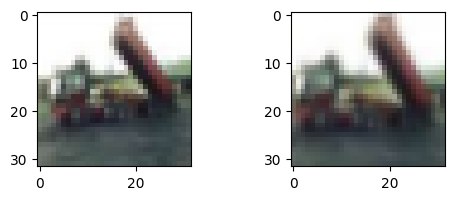

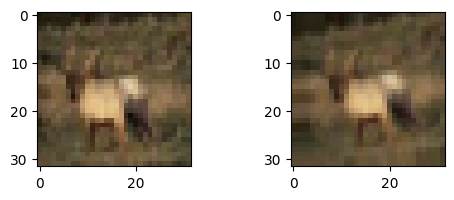

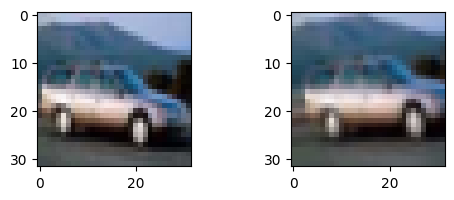

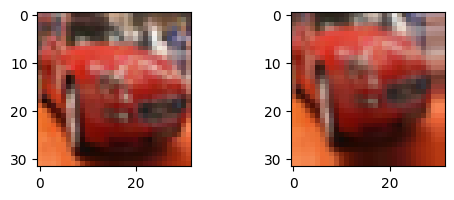

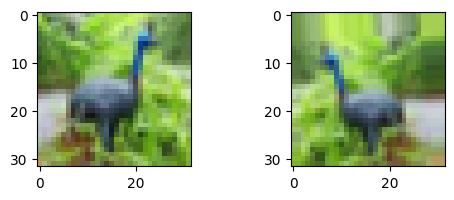

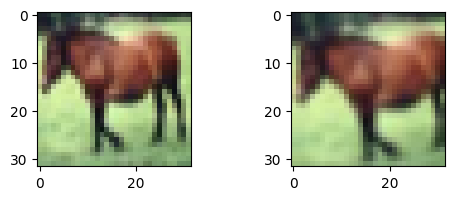

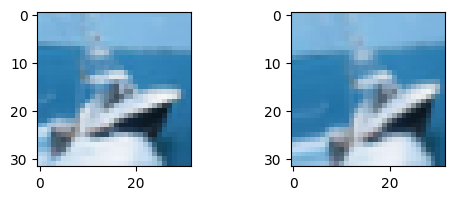

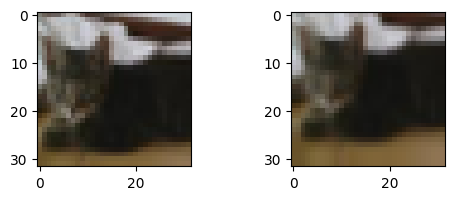

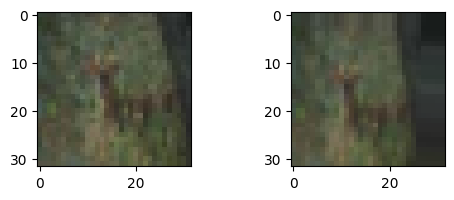

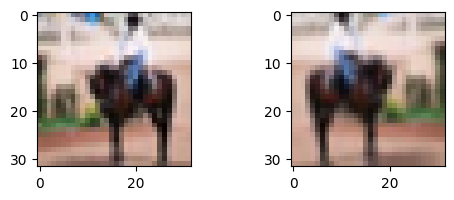

In [23]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()

    if i > 10:
        break

## Applying Data Augmentation

To further improve the model's performance, we apply **data augmentation** to artificially increase the diversity of the training data. Data augmentation helps the model generalize better and reduces overfitting.

### Steps:
1. **Initialize a New Model**:
   - A fresh model is initialized and compiled using the same architecture and configuration as before.

2. **Split the Training Data**:
   - The training data is split into two parts:
     - The first 40,000 images are used for training with data augmentation.
     - The spare subset of the dataset for validation.

3. **Remain : Data Augmentation Generator**:
   - The `ImageDataGenerator` is configured with the following transformations:
     - Random rotation (`rotation_range=10`).
     - Random width and height shifts (`width_shift_range=0.1`, `height_shift_range=0.1`).
     - Random horizontal flipping (`horizontal_flip=True`).
     - Random zooming (`zoom_range=(0.8, 1.2)`).
   - The generator is fitted to the training data (`datagen.fit(X_tr)`).

4. **Early Stopping**:
   - Early stopping is applied with a patience of 3 epochs to prevent overfitting.

5. **Training the Model**:
   - The model is trained using the augmented data (`train_flow`) for up to 100 epochs.
   - The validation data (`X_val`, `y_val`) is used to monitor the model's performance during training.

In [25]:
# The model
model_aug = initialize_model()
model_aug = compile_model(model_aug)

# The data generator
X_tr = X_train[:40000] #40000 firsts images for train
y_tr = y_train[:40000] #40000 firsts images for label
X_val = X_train[40000:] # spare of dataset for test
y_val = y_train[40000:]
train_flow = datagen.flow(X_tr, y_tr, batch_size = 64)

# Add same early stopping criterion
es = EarlyStopping(patience = 3)

# The fit
history_aug = model_aug.fit(train_flow,
                        epochs = 100,
                        callbacks = [es],
                        validation_data = (X_val, y_val))

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 106ms/step - accuracy: 0.1986 - loss: 2.1333 - val_accuracy: 0.4036 - val_loss: 1.6916
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.3684 - loss: 1.7368 - val_accuracy: 0.4368 - val_loss: 1.5767
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.4120 - loss: 1.6215 - val_accuracy: 0.4846 - val_loss: 1.4717
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.4357 - loss: 1.5512 - val_accuracy: 0.5199 - val_loss: 1.4158
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 113ms/step - accuracy: 0.4601 - loss: 1.4982 - val_accuracy: 0.5296 - val_loss: 1.3329
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.4741 - loss: 1.4598 - val_accuracy: 0.5426 - val_loss: 1.2760
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.4957 - loss: 1.4081 - val_accuracy: 0.5779 - val_loss: 1.2062
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.5050 -

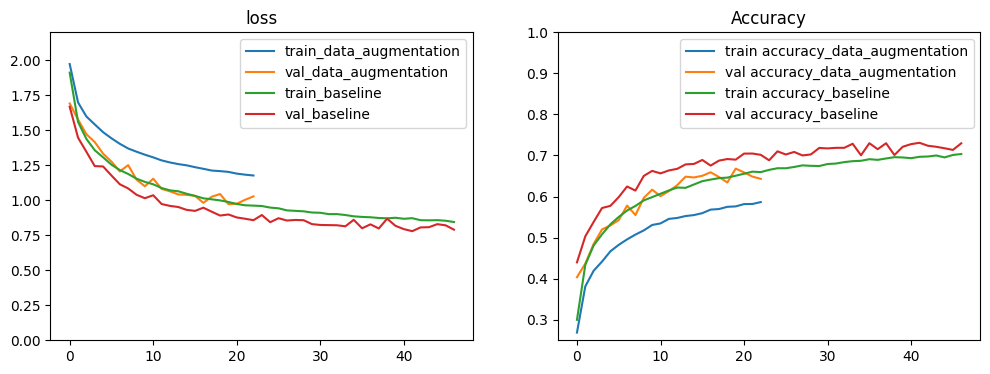

In [26]:
axs = plot_history(history_aug, exp_name = 'data_augmentation')
plot_history(history ,axs = axs, exp_name='baseline')
plt.show()

### Results After Data Augmentation

After applying data augmentation, the model was evaluated on the test dataset.

Below are the results and a comparison with the baseline model (without data augmentation).

In [27]:
# Evaluate the baseline model (without data augmentation) on the test set
res_1 = model.evaluate(X_test, y_test, verbose = 0)

# Evaluate the augmented model (with data augmentation) on the test set
res_2 = model_aug.evaluate(X_test, y_test, verbose = 1)

# Print the accuracy for both models
print(f'Accuracy without data augmentation {res_1[1]*100:.2f}%')
print(f'Accuracy with data augmentation {res_2[1]*100:.2f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6353 - loss: 1.0330
Accuracy without data augmentation 72.49%
Accuracy with data augmentation 63.34%


### Analysis of Results

After evaluating the model with and without data augmentation, we observed the following:

- The baseline model (without data augmentation) achieved an accuracy of **72.49%.**

- The model with data augmentation achieved an accuracy of **63.34%**, which was lower than expected.

Due to the computational limitations of the current setup, further experiments such as cross-validation or extensive hyperparameter tuning are not feasible at this time. Each training run takes approximately 1 hour, and more advanced techniques like cross-validation would require significantly more time and resources.

**Comparison**:

The baseline model outperformed the augmented model on the test set.
This suggests that the data augmentation might have introduced too much variability, making it harder for the model to generalize.


### Possible Reasons for Decreased Accuracy

**Over-Augmentation**:

The augmentation parameters (e.g., rotation, zoom, shifts) might have been too aggressive, causing the model to struggle with the increased variability in the training data.

**Model Overfitting**:

The augmented data might have caused the model to overfit to the training set, leading to poorer performance on the test set.

**Hyperparameter Tuning**:

The model's hyperparameters (e.g., learning rate, batch size) might need to be adjusted when using data augmentation to achieve better results.

### Next Steps

**Adjust Augmentation Parameters**: Experiment with less aggressive augmentation parameters to find the optimal settings.

**Hyperparameter Tuning**: Fine-tune the model's hyperparameters to improve performance with augmented data.

**Regularization**:
Add regularization techniques like dropout or L2 regularization to prevent overfitting.

**Cross-Validation**: Use cross-validation to better evaluate the model's performance and avoid overfitting.

**Transfer Learning**: Explore transfer learning by using pre-trained models and fine-tuning them on the CIFAR dataset.

**Hardware Acceleration**: Utilize GPUs or TPUs to accelerate training and enable more extensive experimentation.

### Conclusion

While data augmentation is a powerful technique to improve model generalization, it must be applied carefully. In this case, the augmentation parameters might have been too aggressive, leading to a decrease in accuracy. By adjusting the augmentation settings and tuning the model's hyperparameters, we can potentially improve the performance of the augmented model.

### Closing Note

While the current setup limits further experimentation, the insights gained from this analysis provide a solid foundation for future work. With access to more computational resources, the model's performance can be significantly improved through careful tuning and advanced techniques.

This concludes the analysis of data augmentation for the CIFAR dataset.